# Simulation

[[1]](https://github.com/eitcom/pyEIT)

In [1]:
# coding: utf-8
""" demo on forward 2D """
# Copyright (c) Benyuan Liu. All Rights Reserved.
# Distributed under the (new) BSD License. See LICENSE.txt for more info.
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pyeit.eit.protocol as protocol
import pyeit.mesh as mesh
from pyeit.eit.fem import EITForward, Forward
from pyeit.eit.interp2d import pdegrad, sim2pts
from pyeit.mesh.shape import thorax
from pyeit.mesh.wrapper import PyEITAnomaly_Circle

from src.util import plot_mesh

In [ ]:
""" 0. build mesh """
""""test"""
n_el = 16  # nb of electrodes
use_customize_shape = True
if use_customize_shape:
    # Mesh shape is specified with fd parameter in the instantiation, e.g : fd=thorax
    mesh_obj = mesh.create(n_el, h0=0.05, fd=thorax)
else:
    mesh_obj = mesh.create(n_el, h0=0.05)
el_pos = mesh_obj.el_pos

# extract node, element, alpha
pts = mesh_obj.node
tri = mesh_obj.element
x, y = pts[:, 0], pts[:, 1]
mesh_obj.print_stats()

# change permittivity
anomaly = PyEITAnomaly_Circle(center=[0, 0.5], r=0.2, perm=100.0)
mesh_new = mesh.set_perm(mesh_obj, anomaly=anomaly, background=1.0)
perm = mesh_new.perm

anomaly = PyEITAnomaly_Circle(center=[0.2, 0.5], r=0.2, perm=100.0)
mesh_new_2 = mesh.set_perm(mesh_obj, anomaly=anomaly, background=1.0)
perm = mesh_new.perm

2D mesh status:
1012 nodes, 1912 elements


In [31]:
PyEITAnomaly_Circle?

Init signature:
PyEITAnomaly_Circle(
    center: 'Union[np.ndarray, list]',
    perm: 'float' = 1.0,
    r: 'float' = 1.0,
) -> None
Docstring:      Pyeit Anomaly for simulation purpose, 2D circle
File:           ~/miniconda3/lib/python3.12/site-packages/pyeit/mesh/wrapper.py
Type:           ABCMeta
Subclasses:     

In [3]:
protocol_obj = protocol.create(n_el, dist_exc=4, step_meas=1, parser_meas="std")
protocol_obj.ex_mat

array([[ 0,  4],
       [ 1,  5],
       [ 2,  6],
       [ 3,  7],
       [ 4,  8],
       [ 5,  9],
       [ 6, 10],
       [ 7, 11],
       [ 8, 12],
       [ 9, 13],
       [10, 14],
       [11, 15],
       [12,  0],
       [13,  1],
       [14,  2],
       [15,  3]])

In [4]:
""" 1. FEM forward simulations """

# setup EIT scan conditions
# protocol_obj = protocol.create(n_el, dist_exc=7, step_meas=1, parser_meas="std")

# Define electrode current sink and current source
ex_line = protocol_obj.ex_mat[3].ravel()

# calculate simulated data using FEM
fwd = Forward(mesh_new)
f = fwd.solve(ex_line)
f = np.real(f)

In [5]:
# calculate simulated data
fwd = EITForward(mesh_obj, protocol_obj)
v0 = fwd.solve_eit()
v1 = fwd.solve_eit(perm=mesh_new.perm)
v2 = fwd.solve_eit(perm=mesh_new_2.perm)

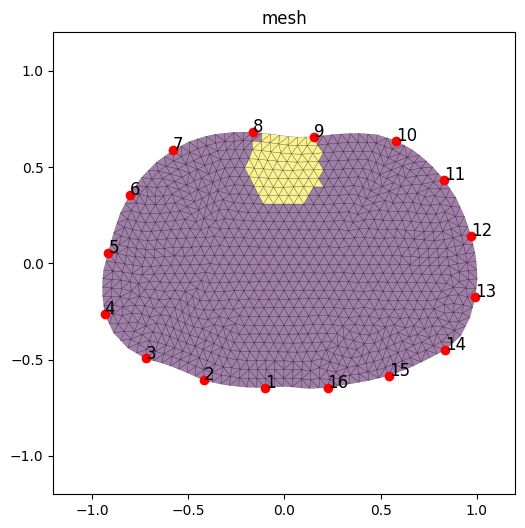

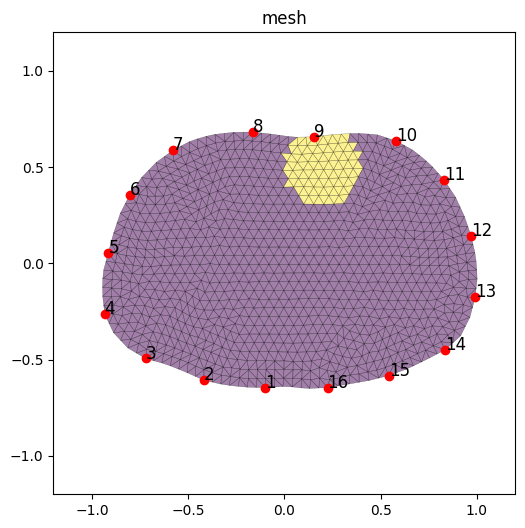

In [6]:
plot_mesh(mesh_new)
plot_mesh(mesh_new_2)

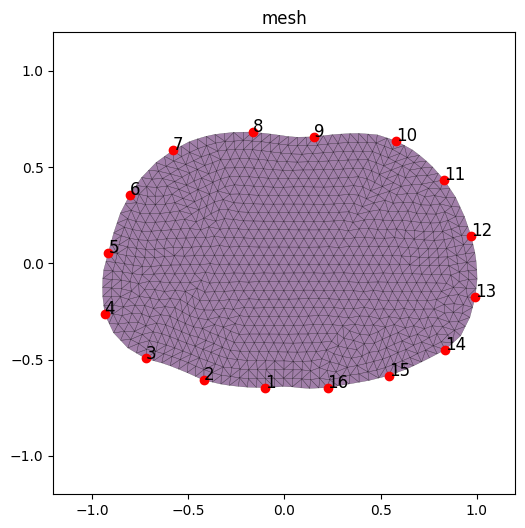

<StemContainer object of 3 artists>

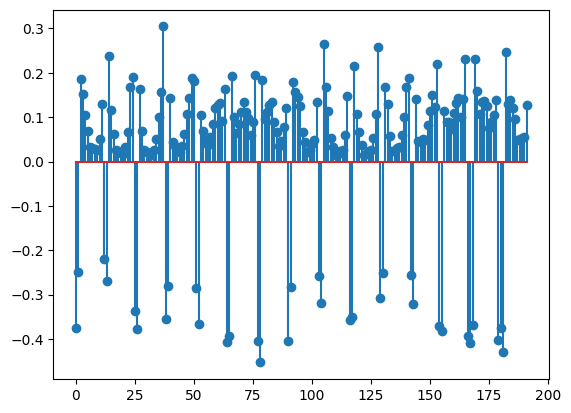

In [7]:
plot_mesh(mesh_obj)
plt.stem(v0)

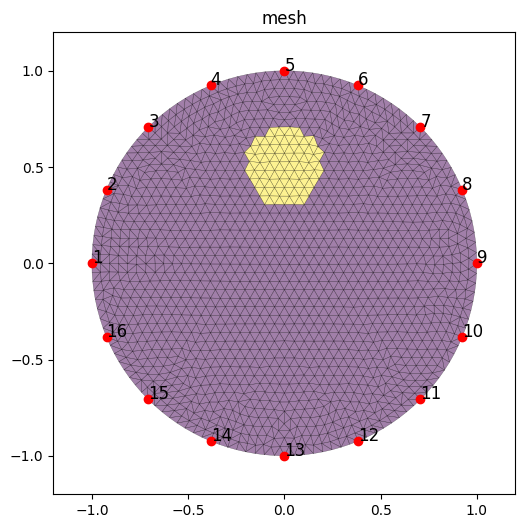

<StemContainer object of 3 artists>

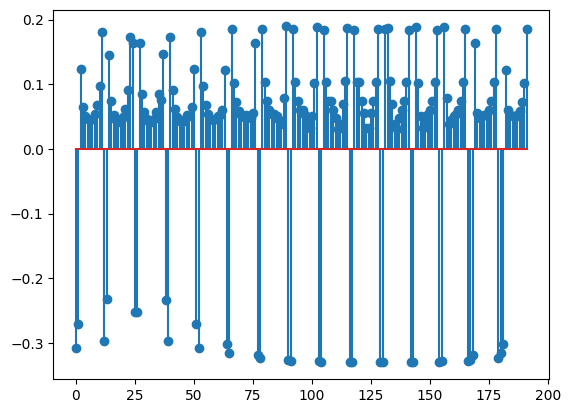

In [80]:
plot_mesh(mesh_new)
plt.stem(v1)

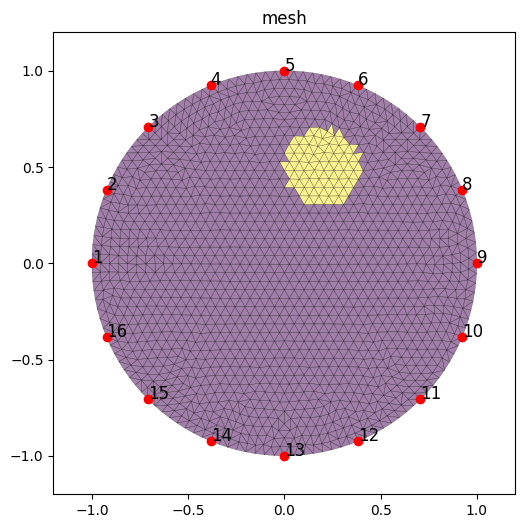

<StemContainer object of 3 artists>

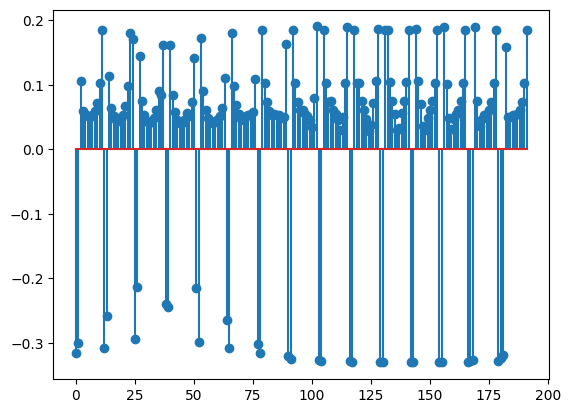

In [81]:
plot_mesh(mesh_new_2)
plt.stem(v2)

<StemContainer object of 3 artists>

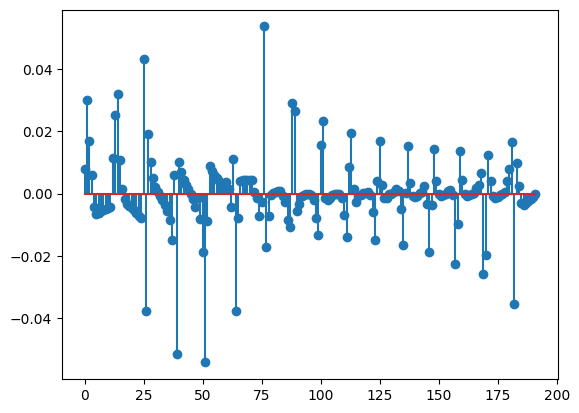

In [82]:
plt.stem(v1 - v2)

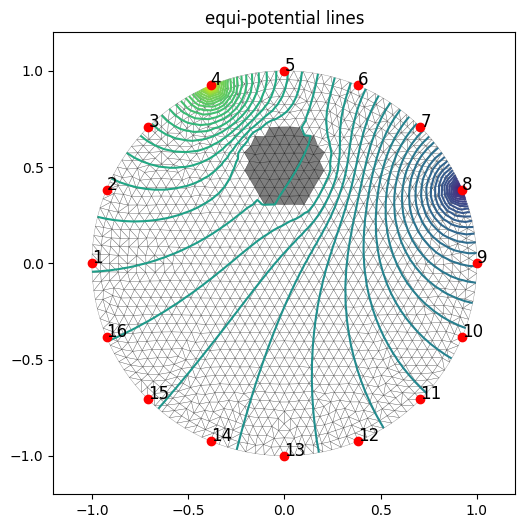

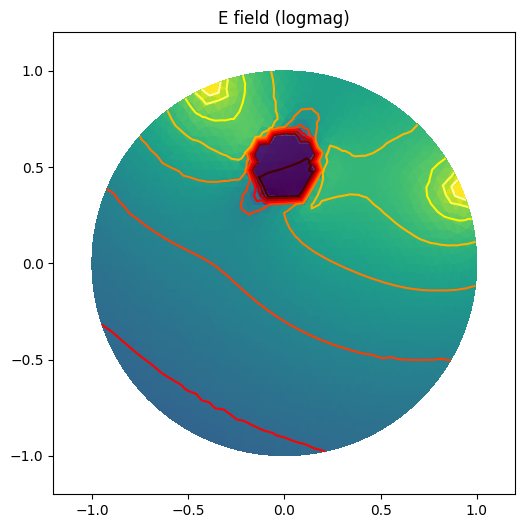

In [83]:
""" 2. plot """

fig, ax1 = plt.subplots(figsize=(9, 6))
# draw equi-potential lines
vf = np.linspace(min(f), max(f), 64)
# vf = np.sort(f[el_pos])
# Draw contour lines on an unstructured triangular grid.
ax1.tricontour(x, y, tri, f, vf, cmap=plt.cm.viridis)

# draw mesh structure
# Create a pseudocolor plot of an unstructured triangular grid
ax1.tripcolor(
    x,
    y,
    tri,
    np.real(perm),
    edgecolors="k",
    shading="flat",
    alpha=0.5,
    cmap=plt.cm.Greys,
)
# draw electrodes
ax1.plot(x[el_pos], y[el_pos], "ro")
for i, e in enumerate(el_pos):
    ax1.text(x[e], y[e], str(i + 1), size=12)
ax1.set_title("equi-potential lines")
# clean up
ax1.set_aspect("equal")
ax1.set_ylim([-1.2, 1.2])
ax1.set_xlim([-1.2, 1.2])
fig.set_size_inches(6, 6)
# fig.savefig('demo_bp.png', dpi=96)
plt.show()

ux, uy = pdegrad(pts, tri, f)
uf = ux**2 + uy**2
uf_pts = sim2pts(pts, tri, uf)
uf_logpwr = 10 * np.log10(uf_pts)

fig, ax = plt.subplots(figsize=(9, 6))
# Draw contour lines on an unstructured triangular grid.
ax.tripcolor(x, y, tri, uf_logpwr, cmap=plt.cm.viridis)
ax.tricontour(x, y, tri, uf_logpwr, 10, cmap=plt.cm.hot)
ax.set_aspect("equal")
ax.set_ylim([-1.2, 1.2])
ax.set_xlim([-1.2, 1.2])
ax.set_title("E field (logmag)")
plt.show()

In [62]:
v0.shape

(192,)

In [65]:
16 * 16

256

In [43]:
np.linspace(0, 2 * np.pi, num=10)

array([0.        , 0.6981317 , 1.3962634 , 2.0943951 , 2.7925268 ,
       3.4906585 , 4.1887902 , 4.88692191, 5.58505361, 6.28318531])

In [39]:
anomaly

PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2)

**save data**

In [42]:
for phi in range(10):
    # create mesh
    # change anomaly
    # solve forward ->v
    np.savez("data/sample_{0:06d}.npz".format(phi), v=v1, anomalie=anomaly)

**load data**

In [45]:
from glob import glob

In [48]:
file_list = np.sort(glob("data/*.npz"))

In [56]:
V = list()  # voltages
A = list()  # anomalies
for file in file_list:
    tmp = np.load(file, allow_pickle=True)
    V.append(tmp["v"])
    A.append(tmp["anomalie"].tolist())

In [57]:
A

[PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2),
 PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2)]

In [58]:
A[3]

PyEITAnomaly_Circle(center=array([0.2, 0.5]), perm=100.0, r=0.2)

In [60]:
A[3].r

0.2